In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Đọc dữ liệu
file_path = '../data/raw/dataset.csv'
data = pd.read_csv(file_path)
columns = [
        'forecast_time_07', 'forecast_date_07',
        'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure','sea_level', 'grnd_level', 'temp_kf', 'humidity',
        'probability_of_precipitation', 'unit_of_precipitation', 'value_of_precipitation', 'weather_main', 
        'weather_description', 'wind_speed', 'wind_deg', 'wind_gust', 'visibility']

data = data[columns]
# Hiển thị thông tin cơ bản về dữ liệu
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35901 entries, 0 to 35900
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   forecast_time_07              35901 non-null  object 
 1   forecast_date_07              35901 non-null  object 
 2   temp                          35901 non-null  float64
 3   feels_like                    35901 non-null  float64
 4   temp_min                      35901 non-null  float64
 5   temp_max                      35901 non-null  float64
 6   pressure                      35901 non-null  float64
 7   sea_level                     35901 non-null  float64
 8   grnd_level                    35901 non-null  float64
 9   temp_kf                       35901 non-null  float64
 10  humidity                      35901 non-null  float64
 11  probability_of_precipitation  35901 non-null  float64
 12  unit_of_precipitation         35901 non-null  object 
 13  v

,forecast_time_07,forecast_date_07,temp,feels_like,temp_min,temp_max,pressure,sea_level,grnd_level,temp_kf,humidity,probability_of_precipitation,unit_of_precipitation,value_of_precipitation,weather_main,weather_description,wind_speed,wind_deg,wind_gust,visibility
0,2024-02-08 19:00:00,2024-02-08,14.00,13.31,13.13,14.00,1018.0,1018.0,1017.0,0.87,71.0,0.0,3h,0.0,Clouds,mây đen u ám,3.85,30.0,6.22,10000.0
1,2024-02-08 22:00:00,2024-02-08,13.60,12.84,12.81,13.60,1019.0,1019.0,1019.0,0.79,70.0,0.0,3h,0.0,Clouds,mây đen u ám,3.04,28.0,5.60,10000.0
2,2024-02-08 19:00:00,2024-02-08,10.89,10.20,10.89,10.89,1019.0,1019.0,999.0,0.00,83.0,0.0,3h,0.0,Clouds,mây đen u ám,1.65,63.0,4.46,10000.0
3,2024-02-08 22:00:00,2024-02-08,10.74,10.04,10.45,10.74,1020.0,1020.0,1001.0,0.29,83.0,0.0,3h,0.0,Clouds,mây đen u ám,1.62,57.0,4.73,10000.0
4,2024-02-08 19:00:00,2024-02-08,14.01,13.29,12.34,14.01,1018.0,1018.0,1017.0,1.67,70.0,0.0,3h,0.0,Clouds,mây đen u ám,4.34,33.0,7.24,10000.0


## convert datetime

In [3]:
data['forecast_time_07'] = pd.to_datetime(data['forecast_time_07'])
data['forecast_date_07'] = pd.to_datetime(data['forecast_date_07'])
data['hour'] = data['forecast_time_07'].dt.strftime("%H").apply(lambda x: int(x))

## Label encoding

In [4]:
label_encoder = LabelEncoder()
data['weather_main'] = label_encoder.fit_transform(data['weather_main'])

## Biểu đồ phân bố weather_main

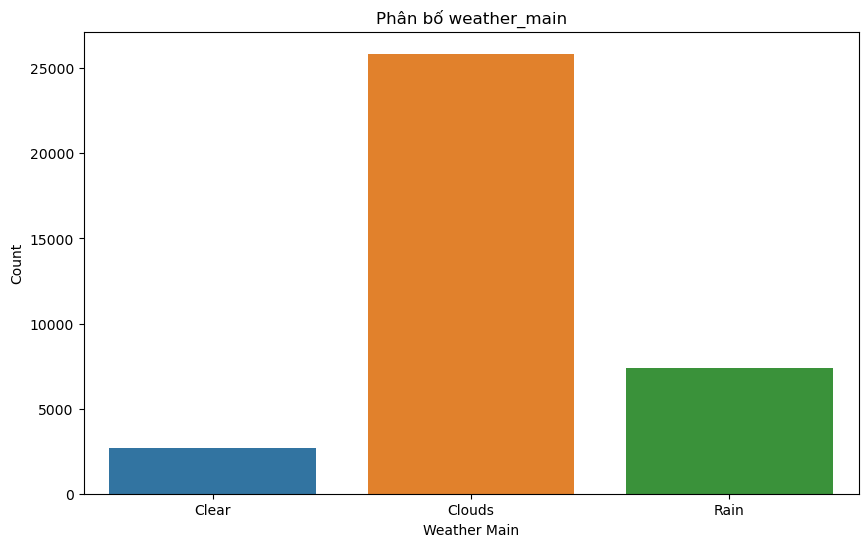

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(x='weather_main', data=data)
plt.title('Phân bố weather_main')
plt.xlabel('Weather Main')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=label_encoder.classes_)
plt.show()

C:\Users\DEL\AppData\Local\Temp\ipykernel_18852\1741253723.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


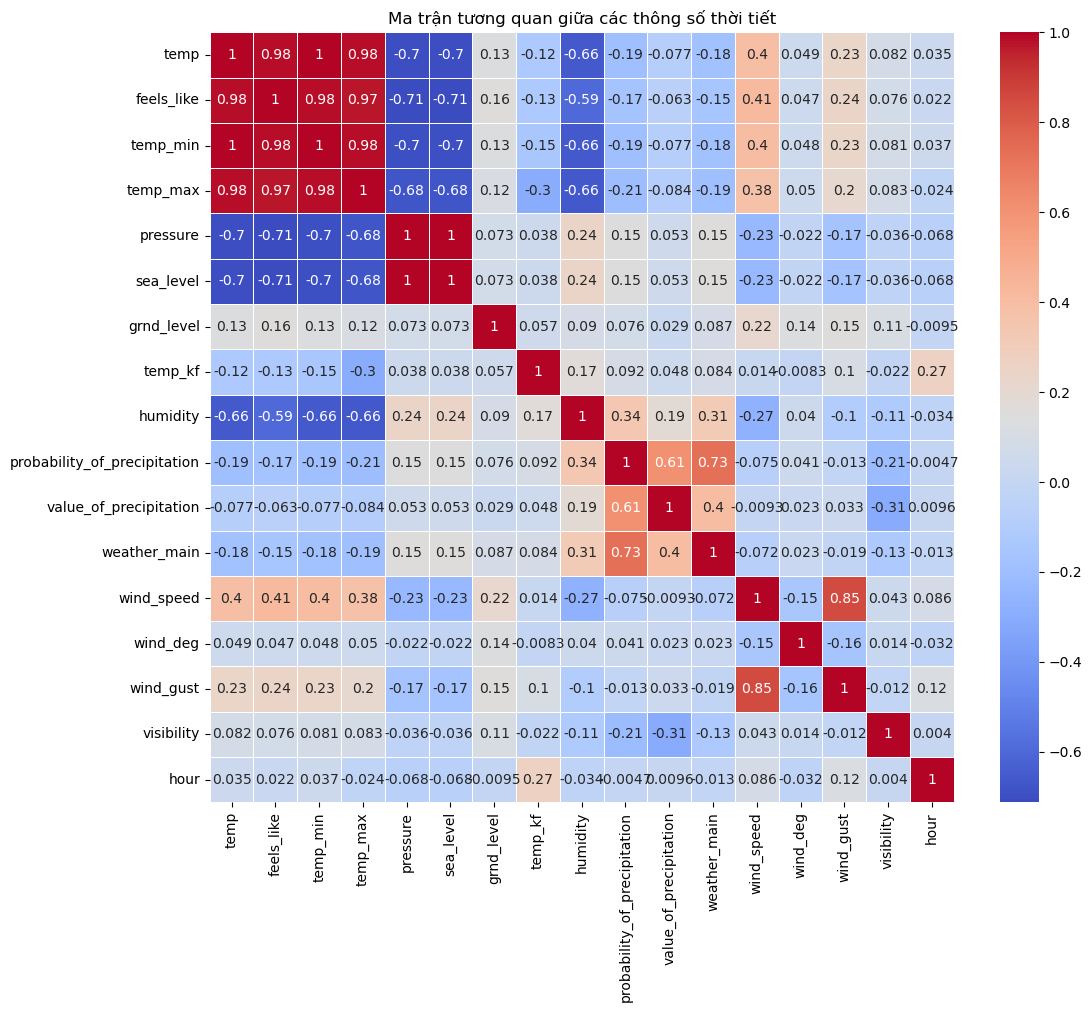

In [6]:
# Ma trận tương quan giữa các thông số thời tiết
plt.figure(figsize=(12, 10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Ma trận tương quan giữa các thông số thời tiết')
plt.show()

## chọn biến
- Chọn các biến có độ tương quan lớn với weather_main
- `temp`, `temp_min`, `tenp_max` có độ tương quan với nhau ~1 => chọn 1 biến đại diện `feels_like`
- `pressure` và `sea_level` có độ tương quan bằng 1 => chọn biến `sea_level` đại diện
- `value_of_precipitation` và `probability_of_precipitation` xác xuất và giá trị lượng mưa => Chọn xác xuất mưa

In [7]:
selected_features = [
    "hour",
    "temp",
    "feels_like",
    "sea_level",
    "humidity",
    "grnd_level",
    "wind_gust",
#     "probability_of_precipitation",
    "value_of_precipitation",
    "wind_speed",
    "visibility"
]

X = data[selected_features]
y = data['weather_main']

## Xây dựng mô hình

In [8]:
def random_forest(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # đánh giá mô hình
    print('Classification Report:')
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Chỉ chọn biến không normalize

Classification Report:
              precision    recall  f1-score   support

       Clear       0.66      0.11      0.19       534
      Clouds       0.92      0.99      0.95      5171
        Rain       1.00      1.00      1.00      1476

    accuracy                           0.93      7181
   macro avg       0.86      0.70      0.72      7181
weighted avg       0.91      0.93      0.91      7181



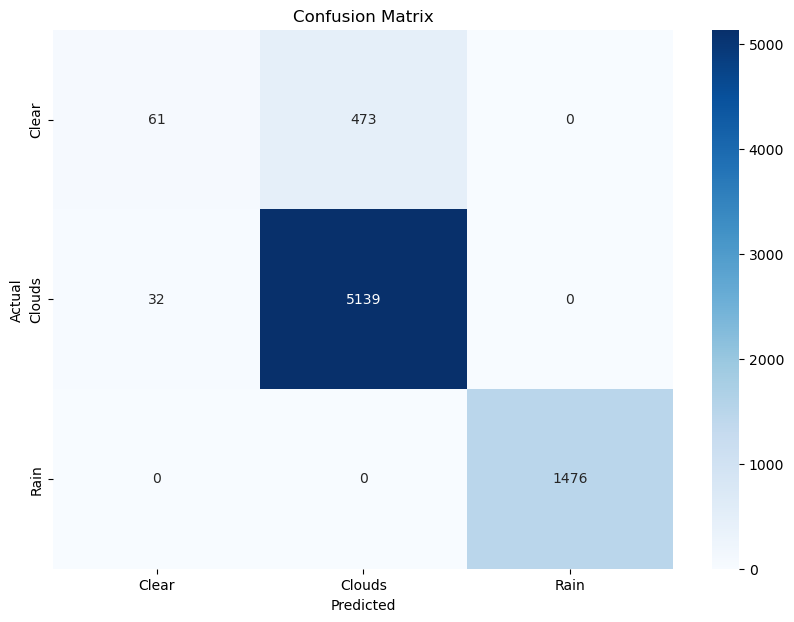

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
random_forest(X_train, X_test, y_train, y_test)

### Mô hình có Normalized Data

Classification Report:
              precision    recall  f1-score   support

       Clear       0.66      0.11      0.19       534
      Clouds       0.92      0.99      0.95      5171
        Rain       1.00      1.00      1.00      1476

    accuracy                           0.93      7181
   macro avg       0.86      0.70      0.72      7181
weighted avg       0.91      0.93      0.91      7181



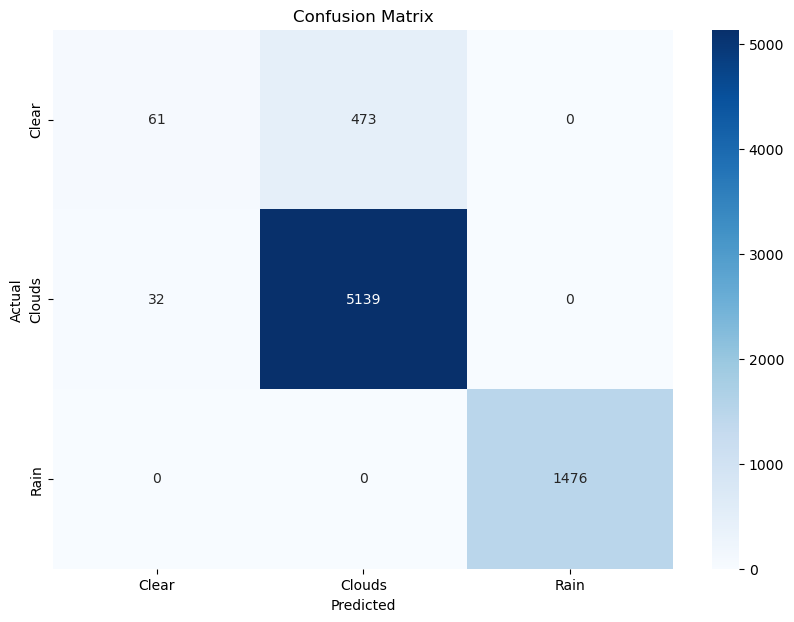

In [10]:
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

random_forest(X_train_normalized, X_test_normalized, y_train, y_test)

### Mô hình Standard

Classification Report:
              precision    recall  f1-score   support

       Clear       0.65      0.11      0.19       534
      Clouds       0.92      0.99      0.95      5171
        Rain       1.00      1.00      1.00      1476

    accuracy                           0.93      7181
   macro avg       0.86      0.70      0.71      7181
weighted avg       0.91      0.93      0.91      7181



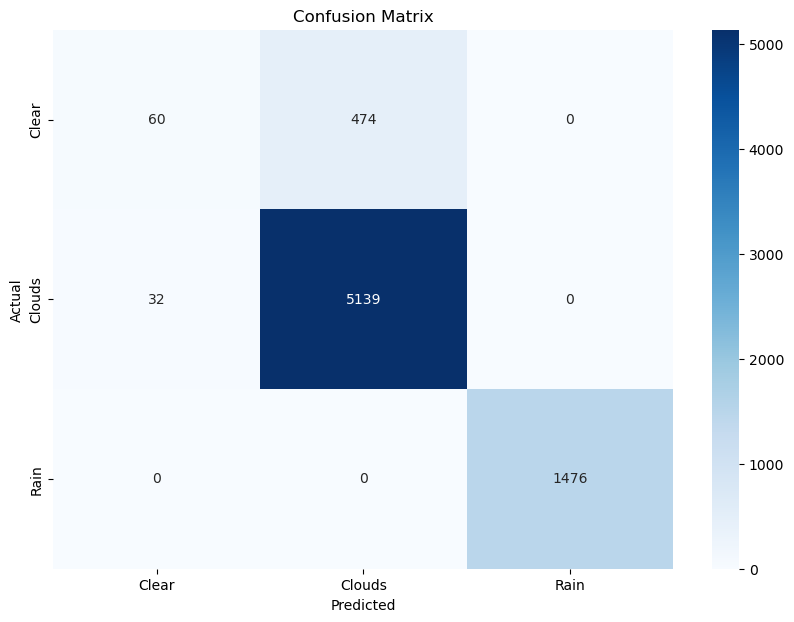

In [11]:
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

random_forest(X_train_standardized, X_test_standardized, y_train, y_test)